In [1]:
from numcosmo_py import Ncm, Nc, GObject
Ncm.cfg_init()
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

DC2_rM_mdata = Table.read('/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/CatalogsMatching/match_ID.fits')
DC2_rM_mdata.rename_column('halo_mass', 'mass')

from numcosmo_py.plotting.tools import set_rc_params_article      # imports Numcosmo plotting tools
set_rc_params_article(ncol=1)

In [2]:
#-------------------------------------------------------------------------------------------------#
# Class: BinnedData 
#-------------------------------------------------------------------------------------------------#

class BinnedData:
    def __init__(self, data_set, z_bin_length, m_bin_length, n_elements):
        self.data_set = data_set
        self.zl = z_bin_length
        self.ml = m_bin_length
        self.n_elem = n_elements
        self.mz_bins = self.get_mz_bins()
        
        
#-------------------------------------------------------------------------------------------------#
# get_mz_bins()
#
# Returns: 
# halos_bin_mz : The bins of the data;
#-------------------------------------------------------------------------------------------------# 
    
    def get_mz_bins(self):

            #To extract data
            z_data, lnm_data = self.data_set["redshift"], np.log(self.data_set["mass"])

            #Number of bins
            z_bins = int((max(z_data) - min(z_data)) // self.zl) + 1
            m_bins = int((max(lnm_data) - min(lnm_data)) // self.ml) + 1
            
            halos_bin_mz = []
            
            for i in range(z_bins):
                cut_z = (z_data > i * self.zl) & (z_data < (i + 1) * self.zl)
                halos_z = self.data_set[cut_z]
                
                for j in range(m_bins):
                    lnM_0, lnM_1 = min(lnm_data) + j * self.ml, min(lnm_data) + (j + 1) * self.ml
                    cut_m = (np.log(halos_z["mass"]) > lnM_0) & (np.log(halos_z["mass"]) < lnM_1)
                    bin_subset = halos_z[cut_m]

                    if len(bin_subset) == self.n_elem:
                        halos_bin_mz.append(bin_subset)
            
            return halos_bin_mz      

    
#-------------------------------------------------------------------------------------------------#
# get_lnM_binned()
#
# Returns: 
# Average of lnM values in each bin.
#-------------------------------------------------------------------------------------------------#    
   
    def get_lnM_binned(self):

        return [np.log(binned_data["mass"]) for binned_data in self.mz_bins]
                       
#-------------------------------------------------------------------------------------------------#
# get_z_binned()
#
# Returns: 
# Average of z values in each bin.
#-------------------------------------------------------------------------------------------------#    
    
    def get_z_binned(self):

        return [binned_data["redshift"] for binned_data in self.mz_bins]

#-------------------------------------------------------------------------------------------------#
# get_lnR_binned()
#
# Returns: 
# Average of lnR values in each bin.
#-------------------------------------------------------------------------------------------------#    
    
    def get_lnR_binned(self):

        return [np.log(binned_data["richness"]) for binned_data in self.mz_bins]
    

#-------------------------------------------------------------------------------------------------#
# get_bins_mean()
#
# Returns: 
# Mean of lnR values in each bin.
#-------------------------------------------------------------------------------------------------#        
  
    def get_bins_mean(self):
                
        # lnR mean, lnM mean and z mean values in each bin:
        richness_mean = [np.average(binned_data["richness"], weights = binned_data["richness_err"] ) for binned_data in self.mz_bins if len(binned_data) > 0]
        
        mass_mean = [np.mean(binned_data["mass"]) for binned_data in self.mz_bins if len(binned_data) > 0]
        
        z_mean = [np.mean(binned_data["redshift"]) for binned_data in self.mz_bins if len(binned_data) > 0]
        
        return Table([richness_mean, mass_mean, z_mean], names=('richness', 'mass', 'redshift'))
    

#-------------------------------------------------------------------------------------------------#
# get_bins_std()
#
# Returns: 
# Std of lnR values in each bin.
#-------------------------------------------------------------------------------------------------#    

    def get_bins_std(self):

        lnr_mean = np.log(self.get_bins_mean()['richness'])

        std = []
        
        for i, lnrbin in enumerate(self.get_lnR_binned()):
        
            N = len(lnrbin)
            d2 = abs(lnrbin - lnr_mean[i])**2
            var = d2.sum() / (N - 1) 
            std.append(var**0.5)

        return std



In [3]:
bd_4 = BinnedData(DC2_rM_mdata, 0.01, 0.05, 4)
bd_10 = BinnedData(DC2_rM_mdata, 0.01, 0.05, 10)
bd_15 = BinnedData(DC2_rM_mdata, 0.01, 0.05, 15)

binned_mean_4 = bd_4 .get_bins_mean()
binned_std_4 = bd_4 .get_bins_std()

binned_mean_10 = bd_10.get_bins_mean()
binned_std_10 = bd_10.get_bins_std()

binned_mean_15 = bd_15.get_bins_mean()
binned_std_15 = bd_15.get_bins_std()



In [4]:
# plt.scatter(np.log(binned_mean["mass"]), binned_std, c='k', s=10)
# plt.xlabel('$\ln M$', fontsize=16)
# plt.ylabel('$\sigma$', fontsize=16)
# plt.title('N = 10')
# plt.grid()
# plt.show()

In [5]:
# import seaborn as sns
# # Aplicar estilo
# sns.set(style="whitegrid")

# # Criar figura
# plt.figure(figsize=(8, 6))

# # Scatter plot estilizado
# plt.scatter(np.log(binned_mean_4["mass"]), binned_std_4, 
#             c='black', edgecolors='k', s=40, alpha=0.8)

# # Rótulos e título
# plt.xlabel(r'$\ln M$', fontsize=18)
# plt.ylabel(r'$\sigma$', fontsize=18)
# plt.title('N = 4', fontsize=20)

# # Melhorar aparência da grade
# plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# # Remover moldura desnecessária
# sns.despine()

# # Mostrar gráfico
# plt.tight_layout()
# plt.savefig('n_10')
# plt.show()

In [6]:
# #plotting in a one figure
# plt.figure(figsize=(16, 4))

# #leftmost
# plt.subplot(1, 3, 1)
# plt.scatter(np.log(binned_mean_4["mass"]), binned_std_4, 
#             c='black', edgecolors='k', s=40, alpha=0.8)

# # Rótulos e título
# plt.xlabel(r'$\ln M$', fontsize=18)
# plt.ylabel(r'$\sigma$', fontsize=18)
# plt.title('N = 4', fontsize=20)

# plt.ylim(bottom=0.0)

# # Melhorar aparência da grade
# plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# # Remover moldura desnecessária
# sns.despine()


# #middle
# plt.subplot(1, 3, 2)
# plt.scatter(np.log(binned_mean_10["mass"]), binned_std_10, 
#             c='black', edgecolors='k', s=40, alpha=0.8)

# # Rótulos e título
# plt.xlabel(r'$\ln M$', fontsize=18)
# plt.ylabel(r'$\sigma$', fontsize=18)
# plt.title('N = 10', fontsize=20)

# plt.ylim(bottom=0.0)

# # Melhorar aparência da grade
# plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# # Remover moldura desnecessária
# sns.despine()

# #rightmost figure
# plt.subplot(1, 3, 3)
# plt.scatter(np.log(binned_mean_15["mass"]), binned_std_15, 
#             c='black', edgecolors='k', s=40, alpha=0.8)

# # Rótulos e título
# plt.xlabel(r'$\ln M$', fontsize=18)
# plt.ylabel(r'$\sigma$', fontsize=18)
# plt.title('N = 15', fontsize=20)

# plt.ylim(bottom=0.0)


# # Melhorar aparência da grade
# plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# # Remover moldura desnecessária
# sns.despine()

# plt.savefig('n_4_10_15')

# plt.show()

In [7]:
bd_2 = BinnedData(DC2_rM_mdata, 0.01, 0.05, 2)

binned_mean_2 = bd_2 .get_bins_mean()
binned_std_2 = bd_2 .get_bins_std()

bd_3 = BinnedData(DC2_rM_mdata, 0.01, 0.05, 3)

binned_mean_3 = bd_3 .get_bins_mean()
binned_std_3 = bd_3 .get_bins_std()

In [8]:
# #plotting in a one figure
# plt.figure(figsize=(16, 4))

# #leftmost
# plt.subplot(1, 3, 1)
# plt.scatter(np.log(binned_mean_2["mass"]), binned_std_2, 
#             c='black', edgecolors='k', s=40, alpha=0.8)

# # Rótulos e título
# plt.xlabel(r'$\ln M$', fontsize=18)
# plt.ylabel(r'$\sigma$', fontsize=18)
# plt.title('N = 2', fontsize=20)

# plt.ylim(bottom=0.0)

# # Melhorar aparência da grade
# plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# # Remover moldura desnecessária
# sns.despine()


# #middle
# plt.subplot(1, 3, 2)
# plt.scatter(np.log(binned_mean_3["mass"]), binned_std_3, 
#             c='black', edgecolors='k', s=40, alpha=0.8)

# # Rótulos e título
# plt.xlabel(r'$\ln M$', fontsize=18)
# plt.ylabel(r'$\sigma$', fontsize=18)
# plt.title('N = 3', fontsize=20)

# plt.ylim(bottom=0.0)

# # Melhorar aparência da grade
# plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# # Remover moldura desnecessária
# sns.despine()

# #rightmost figure
# plt.subplot(1, 3, 3)
# plt.scatter(np.log(binned_mean_4["mass"]), binned_std_4, 
#             c='black', edgecolors='k', s=40, alpha=0.8)

# # Rótulos e título
# plt.xlabel(r'$\ln M$', fontsize=18)
# plt.ylabel(r'$\sigma$', fontsize=18)
# plt.title('N = 4', fontsize=20)

# plt.ylim(bottom=0.0)


# # Melhorar aparência da grade
# plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# # Remover moldura desnecessária
# sns.despine()

# plt.show()

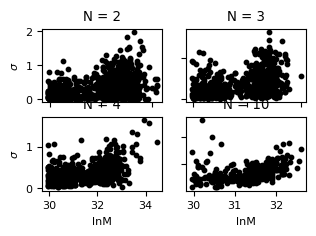

In [9]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(np.log(binned_mean_2["mass"]), binned_std_2, c='k', s=10)
axs[0, 0].set_title('N = 2')

axs[0, 1].scatter(np.log(binned_mean_3["mass"]), binned_std_3, c='k', s=10)
axs[0, 1].set_title('N = 3')

axs[1, 0].scatter(np.log(binned_mean_4["mass"]), binned_std_4, c='k', s=10)
axs[1, 0].set_title('N = 4')

axs[1, 1].scatter(np.log(binned_mean_10["mass"]), binned_std_10, c='k', s=10)
axs[1, 1].set_title('N = 10')

for ax in axs.flat:
    ax.set(xlabel='lnM', ylabel='$\sigma$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

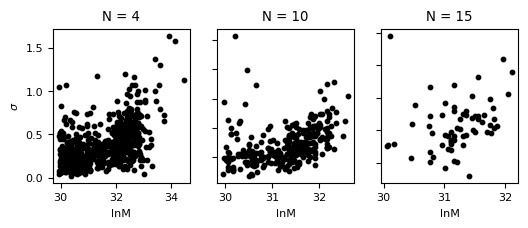

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(6,2))

axs[0].scatter(np.log(binned_mean_4["mass"]), binned_std_4, c='k', s=10)
axs[0].set_title('N = 4')

axs[1].scatter(np.log(binned_mean_10["mass"]), binned_std_10, c='k', s=10)
axs[1].set_title('N = 10')

axs[2].scatter(np.log(binned_mean_15["mass"]), binned_std_15, c='k', s=10)
axs[2].set_title('N = 15')

for ax in axs.flat:
    ax.set(xlabel='lnM', ylabel='$\sigma$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
# fig.tight_layout

plt.savefig('n_4_10_15', dpi=300)

plt.show()